In [1]:
# Import dependencies
import numpy as np
import matplotlib.pyplot as plt
import gmsh
import os
import meshio

from fem.units import mm, cm, m, kgf, N, tf, kN, MPa
from fem import Node, Material, Membrane, CST


In [2]:
# General model parameters

L = 3*m  # Length of the beam
H = 30*cm  # Height of the beam
B = 30*cm  # Width of the beam

fc=28*MPa  # Concrete compressive strength
E=4700*(fc)**0.5  # Concrete modulus of elasticity
nu=0.2  # Concrete Poisson's ratio

lc=100 # Mesh size

output_path=os.path.join(os.path.expanduser("~"), "Documents", "FEM", "Ayudantia", "mesh")  # Path to save the mesh file
mesh_name='beam'  # Name of the mesh file
output_file=os.path.join(output_path, mesh_name + '.msh')  # Full path to the mesh file
if not os.path.exists(output_path):
    os.makedirs(output_path)  # Create the output directory if it doesn't exist

In [3]:
# Create a new GMSH model
gmsh.initialize()
gmsh.model.add("Beam")

# Create the geometry of the beam
# Create the corner points of the beam
p1 = gmsh.model.geo.addPoint(0, 0, 0, lc)
p2 = gmsh.model.geo.addPoint(L, 0, 0, lc)
p3 = gmsh.model.geo.addPoint(L, H, 0, lc)
p4 = gmsh.model.geo.addPoint(0, H, 0, lc)

# Define the lines
l1 = gmsh.model.geo.addLine(p1, p2)
l2 = gmsh.model.geo.addLine(p2, p3)
l3 = gmsh.model.geo.addLine(p3, p4)
l4 = gmsh.model.geo.addLine(p4, p1)

# Define the surface
c1 = gmsh.model.geo.addCurveLoop([l1, l2, l3, l4]) # Create first a curve
s1 = gmsh.model.geo.addPlaneSurface([c1]) # Create a surface from the curve

# Synchronize the model to create the geometry
gmsh.model.geo.synchronize()

# Lauch the GUI to visualize the geometry
gmsh.fltk.run()



In [4]:
# Create the physical groups for the geometry
# gmsh.model.addPhysicalGroup(dim, tags, physicalTag)

gmsh.model.addPhysicalGroup(2, [s1], 201)  # Surface of the beam
gmsh.model.setPhysicalName(2, 201, "Beam")  # Set the name of the physical group

gmsh.model.addPhysicalGroup(1, [l4], 101)  # Left edge of the beam
gmsh.model.setPhysicalName(1, 101, "Support")  # Set the name of the physical group

gmsh.model.addPhysicalGroup(0, [p3], 1)  # Right edge of the beam
gmsh.model.setPhysicalName(0, 1, "Load")  # Set the name of the physical group

# Synchronize the model to create the geometry
gmsh.model.geo.synchronize()

# Lauch the GUI to visualize the geometry
gmsh.fltk.run()



In [5]:
# Create mesh fine control and refinement
# Create transfinite mesh for the surface

gmsh.option.setNumber("Mesh.CharacteristicLengthMin", lc)
gmsh.option.setNumber("Mesh.CharacteristicLengthMax", lc)


gmsh.model.geo.synchronize()
gmsh.model.mesh.generate(2)  # 2D mesh
gmsh.fltk.run()


In [6]:
# Save the mesh to a file
gmsh.write(output_file)  # Save the mesh to a file

In [7]:
#gmsh.finalize()


# FEM Model

In [8]:
concrete=Material(
    name='fc28',
    E=E,
    nu=0.2,
    rho=2.4*tf/m**3,
)

s1=Membrane(
    name='s1',
    material=concrete,
    thickness=B,
)

In [9]:
# Work with the mesh'
mesh=meshio.read(output_file)  # Read the mesh file
print(mesh)  # Print the mesh information


<meshio mesh object>
  Number of points: 155
  Number of cells:
    vertex: 1
    line: 3
    triangle: 242
  Cell sets: Load, Support, Beam, gmsh:bounding_entities
  Point data: gmsh:dim_tags
  Cell data: gmsh:physical, gmsh:geometrical
  Field data: Load, Support, Beam


In [10]:
import numpy as np
from fem import Node  # Asegúrate de importar tu clase

nodes = np.array([
    Node(
        name=i + 1,  # ← empieza en 1 si usas tags Gmsh
        coordenadas=point[0:2]
    )
    for i, point in enumerate(mesh.points)
], dtype=object)  # ← necesario para arrays de objetos personalizados


[]

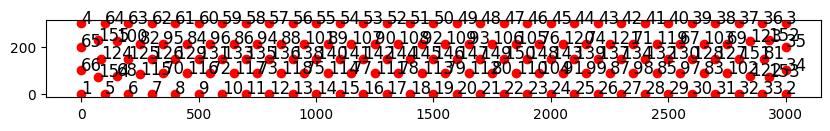

In [11]:
fig, ax = plt.subplots(figsize=(10, 10))  # Create a figure and axis for plotting

for node in nodes:
    node.plotGeometry(ax=ax,
                      text=True)  # Plot each node

ax.set_aspect('equal')  # Mantiene proporciones 1:1
ax.plot()  # Show the plot

In [12]:

elements = []

triangles = mesh.cells_dict['triangle']  # nodos por cada triángulo

for i, node_list in enumerate(triangles):
    nodes_objects=nodes[node_list]
    elem = CST(
        element_tag= i,
        node_list= nodes_objects,
        section= s1
    )
    elements.append(elem)
    
# Convertir la lista a un array de objetos
elements = np.array(elements, dtype=object)



[]

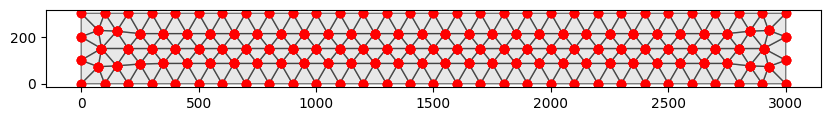

In [13]:
fig, ax = plt.subplots(figsize=(10, 10))  # Create a figure and axis for plotting

for element in elements:
    element.plotGeometry(ax=ax) 

ax.set_aspect('equal')  # Mantiene proporciones 1:1
ax.plot()  # Show the plot

In [14]:
# We create some wrapper functions to access and replace matrix coefficients using row and column indices

def matrix_extract(matrix: np.ndarray, row_indices: np.ndarray, col_indices: np.ndarray) -> np.ndarray:
    """
    Extracts submatrix values from a given matrix using specified row and column indices.

    Args:
        matrix (np.ndarray): The original matrix.
        row_indices (np.ndarray): Indices of the rows to extract.
        col_indices (np.ndarray): Indices of the columns to extract.

    Returns:
        np.ndarray: The extracted submatrix.
    """
    return matrix[np.ix_(row_indices, col_indices)]

def matrix_replace(matrix: np.ndarray, matrix_add: np.ndarray, row_indices: np.ndarray, col_indices: np.ndarray) -> np.ndarray:
    """
    Adds a given submatrix to specific positions in a target matrix.

    Args:
        matrix (np.ndarray): The target matrix.
        matrix_add (np.ndarray): The submatrix to be added.
        row_indices (np.ndarray): Indices of the rows where addition should occur.
        col_indices (np.ndarray): Indices of the columns where addition should occur.

    Returns:
        np.ndarray: A new matrix with the submatrix added to the specified indices.
    """
    # Create a copy to avoid modifying the original matrix
    updated_matrix = matrix.copy()
    
    # Use np.ix_ for better readability and performance
    updated_matrix[np.ix_(row_indices, col_indices)] += matrix_add
    
    return updated_matrix


def get_nodes_in_group(mesh, group_name: str, nodes_array: np.ndarray):
    """
    Devuelve los objetos Node correspondientes al grupo físico indicado.

    Args:
        mesh (meshio.Mesh): Malla cargada con meshio.read(...)
        group_name (str): Nombre del grupo físico (ej. 'Support', 'Load', 'Beam')
        nodes_array (np.ndarray): Arreglo de objetos Node indexado como Gmsh (i+1)

    Returns:
        np.ndarray: arreglo de objetos Node pertenecientes al grupo
    """
    if group_name not in mesh.field_data:
        raise ValueError(f"Grupo físico '{group_name}' no encontrado en la malla")

    group_id, dim = mesh.field_data[group_name]

    # Mapear la dimensión Gmsh a tipo de celda
    dim_to_cell = {0: 'vertex', 1: 'line', 2: 'triangle'}
    if dim not in dim_to_cell:
        raise NotImplementedError(f"No se soporta la dimensión {dim} por ahora")

    cell_type = dim_to_cell[dim]

    if cell_type not in mesh.cells_dict:
        raise ValueError(f"No se encontró '{cell_type}' en mesh.cells_dict")

    elements = mesh.cells_dict[cell_type]
    phys_ids = mesh.cell_data_dict["gmsh:physical"][cell_type]

    # Extraer nodos únicos del grupo físico
    node_ids = [n for e, g in zip(elements, phys_ids) if g == group_id for n in e]
    node_ids = np.unique(node_ids)  # Gmsh → Python indexing

    return nodes_array[node_ids]

In [15]:
mesh.field_data

{'Load': array([1, 0]),
 'Support': array([101,   1]),
 'Beam': array([201,   2])}

In [16]:
mesh.cells_dict

{'vertex': array([[2]]),
 'line': array([[ 3, 64],
        [64, 65],
        [65,  0]]),
 'triangle': array([[ 99, 123, 124],
        [123,  67, 124],
        [121,  80, 150],
        [ 80, 122, 150],
        [ 83,  60,  94],
        [ 59,  83,  95],
        [ 87,  56,  93],
        [ 29,  82,  96],
        [ 27,  84,  97],
        [ 90,  24,  98],
        [ 88,  54, 100],
        [ 85,  58,  95],
        [ 81,  62,  99],
        [ 57,  85,  93],
        [ 61,  81,  94],
        [ 37,  38, 102],
        [ 54,  55, 100],
        [ 55,  56,  87],
        [ 55,  87, 100],
        [ 24,  25,  98],
        [ 84,  28,  96],
        [ 25,  86,  98],
        [ 82,  30, 101],
        [ 86,  26,  97],
        [ 61,  62,  81],
        [ 57,  58,  85],
        [ 59,  60,  83],
        [ 25,  26,  86],
        [ 27,  28,  84],
        [ 29,  30,  82],
        [ 47,  92, 105],
        [ 60,  61,  94],
        [ 56,  57,  93],
        [ 62,  63,  99],
        [ 58,  59,  95],
        [ 28,  29,  96],

In [17]:
mesh.cell_data_dict

{'gmsh:physical': {'vertex': array([1]),
  'line': array([101, 101, 101]),
  'triangle': array([201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201,
         201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201,
         201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201,
         201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201,
         201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201,
         201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201,
         201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201,
         201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201,
         201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201,
         201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201,
         201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201,
         201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201,
         201, 201, 201, 2

In [18]:
support_nodes = get_nodes_in_group(mesh, 'Support', nodes)
for node in support_nodes:
    node.printSummary()

--------------------------------------------
Node 1 at [0. 0.]
Indices:  [0 1]
Nodal Load:  [0. 0.]
Restrain:  ['f' 'f']
--------------------------------------------

--------------------------------------------
Node 4 at [  0. 300.]
Indices:  [6 7]
Nodal Load:  [0. 0.]
Restrain:  ['f' 'f']
--------------------------------------------

--------------------------------------------
Node 65 at [  0. 200.]
Indices:  [128 129]
Nodal Load:  [0. 0.]
Restrain:  ['f' 'f']
--------------------------------------------

--------------------------------------------
Node 66 at [  0. 100.]
Indices:  [130 131]
Nodal Load:  [0. 0.]
Restrain:  ['f' 'f']
--------------------------------------------



In [19]:
for node in support_nodes:
    node.set_restrain(['r', 'r'])
    node.printSummary()

--------------------------------------------
Node 1 at [0. 0.]
Indices:  [0 1]
Nodal Load:  [0. 0.]
Restrain:  ['r' 'r']
--------------------------------------------

--------------------------------------------
Node 4 at [  0. 300.]
Indices:  [6 7]
Nodal Load:  [0. 0.]
Restrain:  ['r' 'r']
--------------------------------------------

--------------------------------------------
Node 65 at [  0. 200.]
Indices:  [128 129]
Nodal Load:  [0. 0.]
Restrain:  ['r' 'r']
--------------------------------------------

--------------------------------------------
Node 66 at [  0. 100.]
Indices:  [130 131]
Nodal Load:  [0. 0.]
Restrain:  ['r' 'r']
--------------------------------------------



In [20]:
load_nodes = get_nodes_in_group(mesh, 'Load', nodes)
for node in load_nodes:
    node.set_nodalLoad([0,-1*tf])
    node.printSummary()

--------------------------------------------
Node 3 at [3000.  300.]
Indices:  [4 5]
Nodal Load:  [    0 -9807]
Restrain:  ['f' 'f']
--------------------------------------------



In [21]:
for node in nodes:
    node.printSummary()

--------------------------------------------
Node 1 at [0. 0.]
Indices:  [0 1]
Nodal Load:  [0. 0.]
Restrain:  ['r' 'r']
--------------------------------------------

--------------------------------------------
Node 2 at [3000.    0.]
Indices:  [2 3]
Nodal Load:  [0. 0.]
Restrain:  ['f' 'f']
--------------------------------------------

--------------------------------------------
Node 3 at [3000.  300.]
Indices:  [4 5]
Nodal Load:  [    0 -9807]
Restrain:  ['f' 'f']
--------------------------------------------

--------------------------------------------
Node 4 at [  0. 300.]
Indices:  [6 7]
Nodal Load:  [0. 0.]
Restrain:  ['r' 'r']
--------------------------------------------

--------------------------------------------
Node 5 at [100.   0.]
Indices:  [8 9]
Nodal Load:  [0. 0.]
Restrain:  ['f' 'f']
--------------------------------------------

--------------------------------------------
Node 6 at [200.   0.]
Indices:  [10 11]
Nodal Load:  [0. 0.]
Restrain:  ['f' 'f']
------------

In [22]:
# We create a general purpose code to ensamble the global stiffness matrix using the element stiffness matrices and its indices

nodeList=nodes
elementList=elements

# Get the number of nodes and elements
nNodes=len(nodeList)
nElements=len(elementList)

# Set the global parameters
globalParameters={'nDoF': 2}

# Get the number of nodes, the number of nodes and the number of degrees of freedom per node define the size of the stiffness matrix
system_nDof = globalParameters['nDoF']*nNodes

print(f'--------------------------------------------')
print(f'Total system nDof: {system_nDof}')
print(f'--------------------------------------------\n')

# Create the global stiffness matrix filled with zeros
Kg=np.zeros((system_nDof,system_nDof))

# Assemble the global stiffness matrix
for i,element in enumerate(elementList):
    Kg=matrix_replace(Kg,element.kg,element.idx,element.idx)

# We assamble the global force vector for the joint loads

print(f'--------------------------------------------')
print(f'Global force vector:\n')

Fj=np.zeros(system_nDof)

# Create load mapping
for i,node in enumerate(nodeList):
    Fj[node.idx]=node.nodalLoad
    
print(f'\n')
print(Fj)

print(f'--------------------------------------------\n')

# We create an index vector with the free and restrained degrees of freedom

nodeIndex=np.full(system_nDof,'',dtype=str)

for i,node in enumerate(nodeList):
    nodeIndex[node.idx]=node.restrain

# Get the indices where the restrains are free and restrained

print(f'--------------------------------------------')

freeIndices=np.where(nodeIndex=='f')[0]
restrainedIndices=np.where(nodeIndex=='r')[0]

print(f'Free indices: {freeIndices}')
print(f'Restrained indices: {restrainedIndices}')

print(f'--------------------------------------------\n')

# Solution procedure
# We partition the global stiffness matrix into Kff, Kfr, Krf and Krr

Kff=matrix_extract(Kg,freeIndices,freeIndices)
Kfr=matrix_extract(Kg,freeIndices,restrainedIndices)
Krf=matrix_extract(Kg,restrainedIndices,freeIndices)
Krr=matrix_extract(Kg,restrainedIndices,restrainedIndices)

# We partition the global force vector into Ff and Fr
Ff=Fj[freeIndices]
Fr=Fj[restrainedIndices]

print(f'--------------------------------------------')
print(f'Partitioned force vector:')
print(f'Ff:\n {Ff}')
print(f'Fr:\n {Fr}')
print(f'--------------------------------------------\n')

# We solve the system of equations
# uf = Kff^-1 * (Ff - Kfr * ur)
uf=np.linalg.solve(Kff,Ff-Kfr@Fr)
ur=np.zeros(len(restrainedIndices))

u=np.zeros(system_nDof)
u[freeIndices]=uf
u[restrainedIndices]=ur

# Fr = Krf * uf + Krr * ur
Fr=Krf@uf+Krr@ur

F_reactions=np.zeros(system_nDof)
F_reactions[restrainedIndices]=Fr

# The joint load vector is:
F=Fj+F_reactions

print(f'--------------------------------------------')
print(f'Displacement Solution:')
print(f'u:\n {u}')
print(f'Reaction Solution:')
print(f'Fr:\n {F}')
print(f'--------------------------------------------\n')




--------------------------------------------
Total system nDof: 310
--------------------------------------------

--------------------------------------------
Global force vector:



[    0.     0.     0.     0.     0. -9807.     0.     0.     0.     0.
     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
     0.     0.     0.     0.     0. 

In [23]:
u[5]

np.float64(-4.622574227361215)

In [24]:
P=1*tf
I=B*H**3/12

delta=P*L**3/(3*E*I)

print(delta)

5.257727073477293


# Results Visualization

In [25]:
# ==========================================================
# PROCESO DE DATA PARA GMSH
# ==========================================================

Nnodes=len(nodes)

u_3d = np.zeros((Nnodes,3))
u_3d[:,0] = u[0::2]
u_3d[:,1] = u[1::2]


In [26]:
node_tags = np.array([node.name for node in nodes]) 

print(node_tags)

[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155]


In [27]:
# ==========================================================
# PROCESO PARA VISUALIZAR EN GMSH
# ==========================================================

gmsh.initialize()

node_tags = np.array([node.name for node in nodes]) 

# Codigo para visualizar en gmsh

viewnum = gmsh.view.add("Displacements")
gmsh.view.addHomogeneousModelData(
	tag=viewnum, 
	step=0,
	time=0, 
	modelName=gmsh.model.getCurrent(),
	dataType="NodeData",
	numComponents=-1,
	tags=node_tags,
	data=u_3d.reshape((-1))
)
# Set displacement field view options
gmsh.view.option.setNumber(viewnum, "DisplacementFactor", 500)
gmsh.view.option.setNumber(viewnum, "VectorType", 5)  # Displacement vectors
gmsh.option.setNumber("Mesh.SurfaceFaces", 0)  # Hide surface faces
gmsh.view.option.setNumber(viewnum, "Visible", 0)


gmsh.view.option.setNumber(viewnum, "Visible", 0)
gmsh.view.option.setNumber(viewnum, "GlyphLocation", 2)  # Ensure vectors are located at the nodes

gmsh.fltk.run()
gmsh.finalize()